In [ ]:

'''
Unscented Kalman filter 

This module demonstrates the Unscented Kalman filter implementation.
Assume the system model:
x(k+1) = f(x(k)) + w(k)
y(k) = h(x(k)) + v(k)
where x is the state, y is the measurement, k is time index, w,v are Gaussian noises with covariance Q,R respectively.
For Kalman filter, please refer to 

UKF
https://web.statler.wvu.edu/~irl/IRL_WVU_Online_UKF_Implementation_V1.0_06_28_2013.pdf

---
Author: Duo HAN
Email: dhanaa@connect.ust.hk
Date: 2017.3.20
'''

In [123]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
def f(x):
    '''
    state update function
    
    User-defined
    '''
    return np.array([[1.1,0],[0.9,1]]).dot(x)
def h(x):
    '''
    observation functioon
    
    User-defined
    '''
    return np.array([[2,3.],[5,6],[1,2]]).dot(x)

In [205]:
class UnscentedKF:
    
    def __init__(self, SysFunc, ObsFunc, Qnoise, Rnoise, SysPara):
        self.L = Qnoise.shape[0]
        self.M = Rnoise.shape[0]
        self.alpha = SysPara[0]
        self.beta = SysPara[1]
        self.kappa = SysPara[2]
        self.lam = (self.alpha**2) * (self.L+self.kappa) - self.L
        self.wm = np.ones((1,2*self.L+1)) / (2*(self.L+self.lam))
        self.wc = np.ones((1,2*self.L+1)) / (2*(self.L+self.lam))
        self.wm[0][0] = self.lam/(self.lam+self.L)
        self.wc[0][0] = self.lam/(self.lam+self.L) + 1 - self.alpha**2 + self.beta
        self.Q = np.copy(Qnoise)
        self.R = np.copy(Rnoise)
        self.f = SysFunc
        self.h = ObsFunc
        print('Initialization complete')
    
    def sigmaUpdate(self,x,p):
        '''
        Generate sigma points
        
        vector/matrix size:
        x: (L,) or (L,1) or (1,L) ----> (L,1)
        SigmaPoints: (L,2L+1)
        '''
        
        #caution: scipy.linalg returns upper and numpy.linalg returns lower
        p_lower = np.linalg.cholesky(p) 
        # reshape x into (L,1)
        x = np.copy(x.reshape(self.L,1))
        # a matrix of L number of x
        x1_ = x.dot(np.ones((1,self.L)))
        # matrix: sqrt(L+lam) * Lower(p)
        x2_ = np.sqrt(self.L+self.lam)*p_lower
        # generate sigma points
        SigmaPoints = np.hstack((x, x1_ + x2_, x1_ - x2_))
        return SigmaPoints

    def UnscentedTransform(self, SigmaPoints):
        '''
        Prediction and Observation transformation
        
        vector/matrix size:
        SigmaPoints: (L,2L+1)
        Xm: (L,2L+1)
        xm: (L,1)
        pm: (L,L)
        wm: (1,2l+1)
        wc: (1,2L+1)
        
        Ym: (M,2L+1)
        ym: (M,1)
        '''
        
        # generate a matrix of f(x) where x is every sigma point
        Xm = np.ones([self.L,2*self.L+1])
        counter = 0
        for x in SigmaPoints.T:
            Xm[:,[counter]] = self.f(x.T).reshape([self.L,1])
            counter += 1
        xm = Xm.dot(self.wm.T)
        # initialize pm with Q
        pm = np.copy(self.Q)
        # add up weighted squared distance
        for i in range(2*self.L+1):
            pm += self.wc[0][i]* ((Xm[:,[i]] - xm)).dot((Xm[:,[i]] - xm).T)
            
        # propagate sigma point through observation
        Ym = np.ones([self.M,2*self.L+1])
        counter = 0
        for x in Xm.T:
            Ym[:,[counter]] = self.h(x.T).reshape([self.M,1])
            counter += 1
        ym = Ym.dot(self.wm.T)
        # calculate Pyy of predicted output
        # calculate cross covariance
        Pyy = np.copy(self.R)
        Pxy = np.zeros((self.L,self.M))
        for i in range(2*self.L+1):
            Pyy += self.wc[0][i] * (Ym[:,[i]] - ym).dot((Ym[:,[i]]- ym).T)
            Pxy += self.wc[0][i] * (Xm[:,[i]] - xm).dot((Ym[:,[i]] - ym).T)
            
        return Pyy, Pxy, ym, xm, pm

    def measurementUpdate(self,Pyy,Pxy,ym,xm,pm,y):
        '''
        Kalman-like measurement update
        '''
        K = Pxy.dot(np.linalg.inv(Pyy))
        x = xm + K.dot((y - ym))
        p = pm - K.dot(Pyy).dot(K.T)
        return x,p
        
    def UKF_oneStep(self,x,p,y):
        '''
        One step UKF update
        
        input: estimate and cov at time k-1, and measurement at time k
        output: estimate and cov at time k
        '''
        SigmaPoints = self.sigmaUpdate(x,p)
        Pyy,Pxy,ym,xm,pm = self.UnscentedTransform(SigmaPoints)
        x,p = self.measurementUpdate(Pyy,Pxy,ym,xm,pm,y)
        
        return x,p
        

Initialization complete


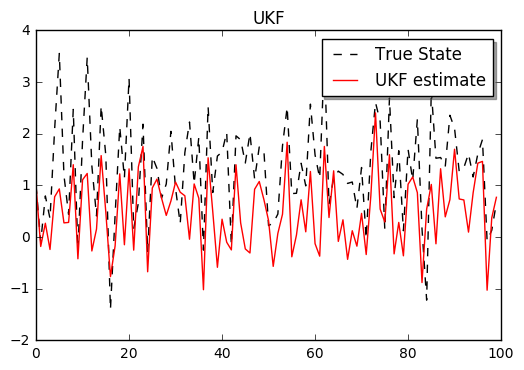

In [228]:
# realize a system
T = 100
n = 2
m = 3
Q = np.eye(n)
R= np.eye(m)
# x(0) and y(0)
x = np.ones((n,1))
x_data = x
y_data = h(x) + np.linalg.cholesky(R).dot(np.random.randn(m,1))


for k in range(1,T):
    # generate x(k)
    _x = f(x)+ np.linalg.cholesky(Q).dot(np.random.randn(n,1))
    x_data = np.hstack((x_data,_x))
    # generate y(k)
    _y =h(_x)+ np.linalg.cholesky(R).dot(np.random.randn(m,1))
    y_data = np.hstack((y_data,_y))


# run the UKF
model = UnscentedKF(SysFunc=f, ObsFunc=h,Qnoise = Q, 
                      Rnoise = R, SysPara = [1.,2.,0.])
x,p = model.UKF_oneStep(x=np.ones(n),p=np.eye(n),y=y_data[:,[0]])
# estimate x(0) and cov p(0)
xEst_data = x
p_data =[p]
for k in range(1,T):
    x,p = model.UKF_oneStep(x,p,y_data[:,[k]])
    xEst_data = np.hstack((xEst_data,x))
    p_data.append(p)

# plot the estimate and true state
time = np.arange(T)
fig, ax = plt.subplots()
ax.plot(time, x_data[0,:], 'k--', label='True State')
ax.plot(time, xEst_data[0,:], 'r', label='UKF estimate')
legend = ax.legend(loc='upper right', shadow=True)
plt.title('UKF')
plt.show()